In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
import joblib 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliensebag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juliensebag/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv("./dataset/training_data_lowercase.csv")
data.reset_index(drop=True, inplace=True)  

data.head()
data[["label", "title"]] = data[data.columns[0]].str.split('\t', n=1, expand=True)

# Convert label to integer
data['label'] = data['label'].astype(int)

# Reorder columns if needed
data = data[['label', 'title']]

data.head()

,label,title
0,0,drunk bragging trump staffer started russian c...
1,0,sheriff david clarke becomes an internet joke ...
2,0,trump is so obsessed he even has obama‚s name ...
3,0,pope francis just called out donald trump duri...
4,0,racist alabama cops brutalize black boy while ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34151 entries, 0 to 34150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34151 non-null  int64 
 1   title   34151 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.7+ KB


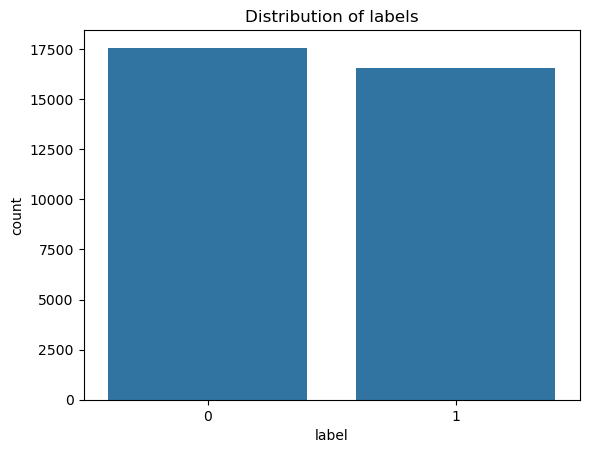

In [5]:
sb.countplot(x='label', data=data)
plt.title("Distribution of labels")
plt.show()

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special chars and digits
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

data['clean_title'] = data['title'].apply(preprocess_text)

In [ ]:
X = data['title'] 
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('clf', LinearSVC())
])

random_forest_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),  # reduce size for RF
    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))  # n_jobs=-1 to use all cores
])

In [ ]:
models = {
    'Random Forest': random_forest_pipeline,
    'Linear SVC': svc_pipeline
}

In [10]:
X = data['title'] 
y = data['label']

results = {}

In [11]:
for name, model in models.items():
    print(f"Evaluating: {name}")
    cv_results = cross_validate(
        model, X, y,
        cv=5,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        n_jobs=-1, 
        return_train_score=False
    )
    results[name] = {
        metric: scores.mean() for metric, scores in cv_results.items() if metric.startswith('test_')
    }

Evaluating: Random Forest
Evaluating: Linear SVC


In [12]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)


Model Comparison:
               test_accuracy  test_precision_macro  test_recall_macro  \
Random Forest       0.896753              0.899634           0.896663   
Linear SVC          0.923019              0.924672           0.923029   

               test_f1_macro  
Random Forest       0.896419  
Linear SVC          0.922866  


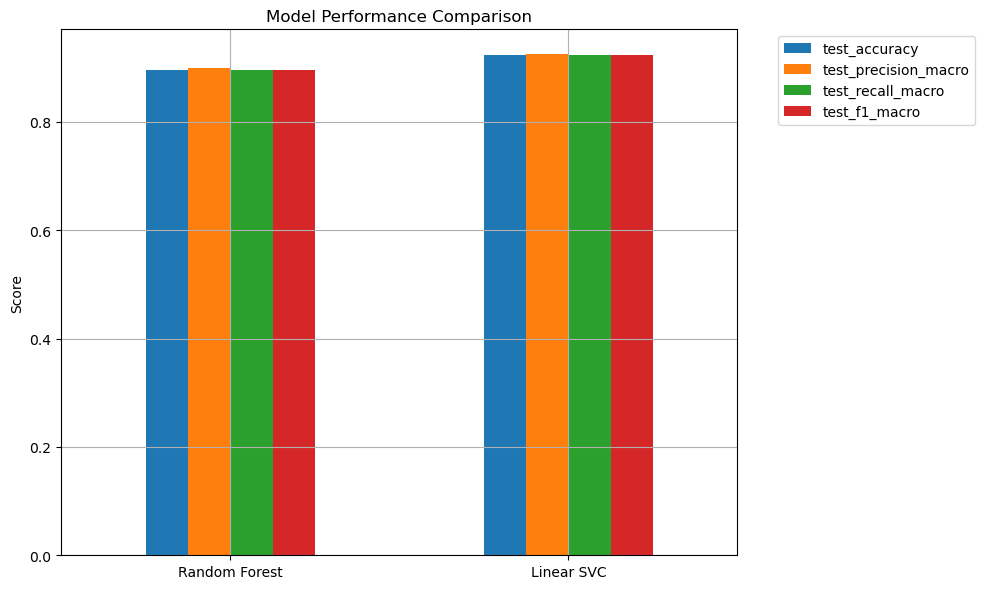

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
